## Fitting profiles with Markov Chain Monte Carlo
This is a jupyter notebook intended to fit stellar density profiles to 
a bunch of clusters simulated. It fits the exponential radius, ellipticity, angular position, background density and center shift in ra and dec.

The code runs reading the position of the stars in a catalog and fitting the pars. After the fitting, the results should be compared to the
truth table (the parameters of the clusters simulated).

Open a terminal and run the following commands to create and activate a new environment and install dependencies:
```
conda create -p $HOME/.conda/envs/emcee_env
conda activate emcee_env
conda install -c astropy emcee
conda install -c conda-forge matplotlib
conda install astropy
conda install -c astropy corner
conda install ipykernel
pip install astropy
ipython kernel install --user --name=emcee_env
```
Activate the environment (if you are running the code in Linea's jupyter notebook). Restart the kernel on the jupyter
notebook and load the new environment (clicking on the env on the top right selection).</br>
Ok, now you are ready to run the code. </br>
You can run this code on any machine since you follow the steps above to create an env and install dependencies.

Run this jupyter notebook in the LIneA env with the following command:
<br>
`jupyter nbconvert --execute --to html --EmbedImagesPreprocessor.embed_images=True fit_prof.ipynb`
<br>
and after the command has finished, run the following cell:
<br>
`cp fit_prof.html ~/public_html/gawa_processes/NNNNN/simulations/fit_profiles/`
where NNNNN is the process number.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import astropy.io.fits as fits
import corner
import json
import os
from multiprocessing import Pool


Below are a few functions (that will be documented in near future!) to provide the results of the fitting.
This is very similar to the main example available on https://emcee.readthedocs.io/en/stable/tutorials/line/ .
Please, visit that page to have a big picture of the fitting.

In [2]:
def lnprior(theta, thmin, thmax):
    """Calculates if pars are within limits.

    Parameters
    ----------
    theta : list
        Set of parameters.

    Returns
    -------
    float
        Zero or -infinity
    """
    re, ell, th, bg, xc, yc = theta
    if 0.01 < re < 5.0 and 0.0 < ell < 0.6 and thmin < th < thmax and 0.0 < bg < 10. and -3. < xc < 3. and -3. < yc < 3.:
        return 0
    return -np.inf


def lnlike(theta, RA, DEC):
    """Calculates likelihood of a specific set of parameters.

    Parameters
    ----------
    theta : list
        Set of parameters.
    RA : list
        RA of stars, in degrees.
    DEC : list
        DEC of stars, in degrees.

    Returns
    -------
    float
        2*ln likelihood
    """

    re, ell, th, bg, xc, yc = theta
    dX = (RA-(ra0+xc/60.))*np.cos(np.radians(dec0))
    dY = (DEC-(dec0+yc/60.))
    ri = 60.*np.sqrt(((dX*np.cos(np.radians(100*th))-dY*np.sin(np.radians(100*th)))/(1.-ell))
                     ** 2.+(dX*np.sin(np.radians(100*th))+dY*np.cos(np.radians(100*th)))**2.)
    #s0 = (len(RA)-bg*3600.)/((1-ell)*2.*np.pi*re**2)

    #idbg = (ri < 60*R0) & (ri > 60*R1)
    #area_annulus_arcmin = 3600. * np.pi * (R0 ** 2 - R1 ** 2)
    # bg = len(RA[idbg])/ area_annulus_arcmin  # stars/arcmin^2
    # N_star = (len(RA[R < 60.*R0])-(robg * 3600. * np.pi * R0 ** 2))
    s0 = (len(RA)-bg*3600.)/((1-ell)*2.*np.pi*re**2)

    if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
        return -np.inf
    return 2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))


def lnprob(theta, RA, DEC, thmin, thmax):
    """Accounts two previous functions.

    Parameters
    ----------
    theta : list
        set of parameters.
    RA : list
        RA of stars in degrees.
    DEC : list
        DEC of stars in degrees.

    Returns
    -------
    float
        Likelihood. If within the limits it is a number.
    """
    lp = lnprior(theta, thmin, thmax)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, RA, DEC)

In [3]:
# reading config file
with open("fit.json") as f:
    param = json.load(f)
globals().update(param)

os.system('mkdir -p ' + export_dir)

0

In [4]:
HPX_, ra0_, dec0_, re_kick_, ell_kick_, pa_kick_, dist = np.loadtxt(
    clusters_list_file, usecols=(0, 9, 10, 11, 12, 13, 15), unpack=True)

# Converting exponential radius from parsecs to arcmin
re_kick = 60. * (180. / np.pi) * np.arctan(re_kick_ / dist)

hdu = fits.open(cat_input, memmap=True)
RA_ = hdu[1].data.field('ra')
DEC_ = hdu[1].data.field('dec')
hdu.close()

fff = open(export_dir + 'results.dat', 'w')

print('# HPX re(0,+,-) ell(0,+,-) pa(0,+,-) robg(0,+,-) shift_ra(0,+,-) shift dec(0,+,-)', file=fff)

for i in range(len(ra0_)):
    reinf = 0.5 * re_kick[i]
    resup = 1.5 * re_kick[i]
    thmin = (pa_kick_[i] - 45.) / 100
    thmax = (pa_kick_[i] + 45.) / 100
    
    ra0 = ra0_[i]
    dec0 = dec0_[i]

    cutout_size_RA = R0 / np.cos(np.deg2rad(dec0))

    cond = (RA_ > ra0 - cutout_size_RA) & (RA_ < ra0 +
                                           cutout_size_RA) & (DEC_ > dec0 - R0) & (DEC_ < dec0 + R0)
    RA = RA_[cond]
    DEC = DEC_[cond]

    re_ml = (reinf + resup)/2.
    ell_ml = 0.05
    th_ml = (thmin + thmax) / 2.
    
    R = 60.*np.sqrt(((np.cos(np.radians(dec0))*(ra0-RA))**2.)+(DEC-dec0)**2) # in arcmin

    idbg = (R < 60.*R0) & (R > 60.*R1)
    area_annulus_arcmin = 3600. * np.pi*(R0**2 - R1**2) #  * np.cos(np.radians(dec0))
    robg = len(RA[idbg]) / area_annulus_arcmin  # stars/arcmin^2

    N_star = (len(RA[R < 60.*R0])-(robg*3600.*np.pi * R0 ** 2))
    s_ml = N_star/(2.*np.pi*re_ml**2)
    xc_ml = 0.0
    yc_ml = 0.0
    result = re_ml, ell_ml, th_ml, robg, xc_ml, yc_ml
    print(result)

    ndim, nwalkers = 6, 300  # 300
    pos = [result + 2e-4*np.random.randn(ndim) for j in range(nwalkers)]
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, lnprob, args=(RA, DEC, thmin, thmax), pool=pool)
        sampler.run_mcmc(pos, 300)  # 200
    samples = sampler.chain[:, 150:, :].reshape((-1, ndim))

    samples[:, 2] = 100.*(samples[:, 2])
    re_mcmc, ell_mcmc, th_mcmc, robg_mcmc, xc_mcmc, yc_mcmc = map(lambda v: (
        v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    
    N_star_0 = (len(RA)-(robg_mcmc[0] * 3600.))
    N_star_m = N_star_0 - (len(RA)-((robg_mcmc[0] + robg_mcmc[1])* 3600.))
    N_star_p = (len(RA)-((robg_mcmc[0] - robg_mcmc[2])* 3600.)) - N_star_0
    print(int(HPX_[i]), re_mcmc[0], re_mcmc[1], re_mcmc[2], ell_mcmc[0], ell_mcmc[1], ell_mcmc[2],
          th_mcmc[0], th_mcmc[1], th_mcmc[2], robg_mcmc[0], robg_mcmc[1], robg_mcmc[2],
          xc_mcmc[0], xc_mcmc[1], xc_mcmc[2], yc_mcmc[0], yc_mcmc[1], yc_mcmc[2], N_star_0, N_star_p, N_star_m, file=fff)
    
    # Plotting best-fitting pars
    fig = corner.corner(samples, labels=["$re$", "$ell$", "$th$", r"$\rho_{bg}$", r"$\Delta\alpha$", r"$\Delta\delta$"],
                        # truths=[re_mcmc[0], ell_mcmc[0], th_mcmc[0], robg_mcmc[0], xc_mcmc[0], yc_mcmc[0]],
                        truths=[re_kick[i], ell_kick_[i], pa_kick_[i], robg, 0.0000, 0.0000],
                        quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_contours=True)
    value1 = [re_kick[i], ell_kick_[i], pa_kick_[i], 0.0000, 0.0000]
    plt.savefig(export_dir + str(int(HPX_[i])) + '_plus.png')
    plt.close()
    '''
    L = np.zeros(len(RA))
    dX = (RA-(ra0+xc_mcmc[0]/60.))*np.cos(np.radians(dec0))
    dY = (DEC-(dec0+yc_mcmc[0]/60.))
    ri = 60.*np.sqrt(((dX*np.cos(np.radians(100*th_mcmc[0]))-dY*np.sin(np.radians(100*th_mcmc[0])))/(
        1.-ell_mcmc[0]))**2.+(dX*np.sin(np.radians(100*th_mcmc[0]))+dY*np.cos(np.radians(100*th_mcmc[0])))**2.)
    L = (np.exp(-ri/re_mcmc[0]))
    '''
    # Saving chains
    fig1, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["rexp", "ell", "theta", "rho_bg", "Ddelta", "Dalpha"]
    for j in range(ndim):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.savefig(export_dir + str(int(HPX_[i])) + '_chains.png')
    plt.close()
fff.close()

(1.7262256793447468, 0.05, 0.45170000000000005, 0.6782505792411558, 0.0, 0.0)
(1.214062467709508, 0.05, 1.3671000000000002, 0.6734611943795942, 0.0, 0.0)
(2.58349035301474, 0.05, 0.24629999999999996, 0.6896714200648798, 0.0, 0.0)
(1.9577386206292704, 0.05, 1.0501999999999998, 0.6517247553925066, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.3076669715675462, 0.05, 1.0756000000000001, 0.692987148045961, 0.0, 0.0)
(2.003651511932976, 0.05, 1.7016999999999998, 0.6977765329075226, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if n

(1.7161758508248854, 0.05, 1.4767, 0.6697770521783929, 0.0, 0.0)
(0.9528757611760877, 0.05, 0.1882, 0.6605666966753897, 0.0, 0.0)
(1.9193207361959537, 0.05, 0.5452, 0.6771453365807955, 0.0, 0.0)
(1.4925733982225795, 0.05, 0.1631, 0.6885661774045194, 0.0, 0.0)
(1.2620578628312114, 0.05, 0.8838999999999999, 0.7062500599702856, 0.0, 0.0)
(2.3831895073666436, 0.05, 0.2802, 0.6940923907063213, 0.0, 0.0)
(2.2481459834042323, 0.05, 1.5827, 0.6705138806186332, 0.0, 0.0)
(2.3113687443577335, 0.05, 0.21980000000000005, 0.6911450769453603, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if n

(2.3450255059333864, 0.05, 1.7049999999999998, 0.6896714200648798, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(2.9154632215997407, 0.05, 0.08579999999999996, 0.7077237168507661, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.3110915504258847, 0.05, 1.6068, 0.681566307222237, 0.0, 0.0)
(2.173829314371941, 0.05, 0.2991, 0.6933555622660811, 0.0, 0.0)
(2.880268632840948, 0.05, 1.3922999999999999, 0.6948292191465616, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.6830983416519631, 0.05, 1.4693, 0.6985133613477629, 0.0, 0.0)
(1.2145706701158394, 0.05, 1.0755, 0.6863556920837987, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.5790564927519526, 0.05, 1.3285, 0.6782505792411558, 0.0, 0.0)
(0.909328357306833, 0.05, 0.24579999999999996, 0.6859872778636785, 0.0, 0.0)
(1.6620318993428842, 0.05, 0.9863, 0.6896714200648798, 0.0, 0.0)
(1.5497779326955567, 0.05, 0.4039, 0.7036711604294447, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(2.0885889534805737, 0.05, 0.11350000000000002, 0.6624087677759903, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if n

(1.4236066688036861, 0.05, 1.316, 0.6668297384174319, 0.0, 0.0)
(2.8666044403355917, 0.05, 0.2319, 0.6848820352033181, 0.0, 0.0)
(1.6125713540836821, 0.05, 0.02259999999999998, 0.6966712902471622, 0.0, 0.0)
(2.1775982660804907, 0.05, 0.18480000000000002, 0.6922503196057207, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.8483097977928111, 0.05, 0.1339, 0.6775137508009156, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.1263028387549734, 0.05, 0.6457999999999999, 0.7117762732720875, 0.0, 0.0)
(2.338962830296922, 0.05, 0.5659000000000001, 0.6859872778636785, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.5062160427391202, 0.05, 0.2924, 0.6881977631843993, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.264852662000254, 0.05, 0.2484, 0.6432512283297437, 0.0, 0.0)
(1.8211184566925072, 0.05, 1.2555, 0.6561457260339482, 0.0, 0.0)
(1.4070799179038271, 0.05, 0.8814, 0.687460934744159, 0.0, 0.0)
(2.396982550444359, 0.05, 1.4725000000000001, 0.7254075994165323, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if n

(1.4228017631929717, 0.05, 1.2706, 0.6738296085997143, 0.0, 0.0)
(1.4088283674469395, 0.05, 0.24870000000000006, 0.6594614540150293, 0.0, 0.0)
(1.2961032483943917, 0.05, 1.7383000000000002, 0.6767769223606753, 0.0, 0.0)
(1.6443809936073155, 0.05, 1.1020999999999999, 0.6708822948387533, 0.0, 0.0)
(1.6691945882079915, 0.05, 1.2792000000000001, 0.6741980228198344, 0.0, 0.0)
(1.5969902605777926, 0.05, 0.5503, 0.7084605452910063, 0.0, 0.0)
(1.4128942230968087, 0.05, 1.3282, 0.6830399641027175, 0.0, 0.0)
(1.3589511604964852, 0.05, 0.0658, 0.6841452067630779, 0.0, 0.0)
(2.4929257590374574, 0.05, 1.6734, 0.6679349810777923, 0.0, 0.0)
(1.3758677610378913, 0.05, 0.4462, 0.6712507090588734, 0.0, 0.0)
(2.114253486741097, 0.05, 0.4965, 0.7040395746495648, 0.0, 0.0)
(2.4211956559189995, 0.05, 0.19329999999999997, 0.6948292191465616, 0.0, 0.0)
(2.2411981457587764, 0.05, 1.0201999999999998, 0.6694086379582728, 0.0, 0.0)
(1.8606630466285055, 0.05, 0.7981, 0.6797242361216363, 0.0, 0.0)
(2.51340478060740

/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.0745522773505842, 0.05, 0.9067000000000001, 0.678618993461276, 0.0, 0.0)
(1.0603639959382973, 0.05, 0.23680000000000004, 0.6764085081405552, 0.0, 0.0)
(1.3440972950656247, 0.05, 0.22249999999999998, 0.6550404833735878, 0.0, 0.0)
(1.8194295325334369, 0.05, 0.3834, 0.7014606751087239, 0.0, 0.0)
(3.2216074247637523, 0.05, 1.4719, 0.713249930152568, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if n

(1.3935827676212165, 0.05, 0.8872, 0.6590930397949092, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(1.433385968884074, 0.05, 1.2073, 0.6830399641027175, 0.0, 0.0)
(1.6351228340508213, 0.05, 0.48819999999999997, 0.670145466398513, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(2.662658223025026, 0.05, 0.10610000000000003, 0.678618993461276, 0.0, 0.0)
(1.0953917803639057, 0.05, 0.5226, 0.6915134911654804, 0.0, 0.0)
(1.635397474552308, 0.05, 1.7496, 0.7110394448318472, 0.0, 0.0)


/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):
/tmp/ipykernel_35014/3300783791.py:51: RuntimeWarning: invalid value encountered in log
  if not np.isfinite(2.*np.sum(np.log(bg+s0*np.exp(-ri/re)))):


(0.9246064127625369, 0.05, 0.9867000000000001, 0.6793558219015162, 0.0, 0.0)


In [14]:
HPX, re_bf, re_bf_p, re_bf_m, ell_bf, ell_bf_p, ell_bf_m, th_bf, th_bf_p, th_bf_m, \
robg_bf, robg_bf_p, robg_bf_m, xc_bf, xc_bf_p, xc_bf_m, yc_bf, yc_bf_p, yc_bf_m, nstar_bf, nstar_bf_p, nstar_bf_m = \
np.loadtxt(export_dir + 'results.dat', unpack=True)
# Truth table : HPX_, ra0_, dec0_, re_kick_, ell_kick_, pa_kick_, dist
# 0-HPX64 1-N 2-MV 3-SNR 4-N_f 5-MV_f 6-SNR_f 7-L 8-B 9-ra 10-dec 11-r_exp 12-ell 13-pa 14-mass 15-dist
HPX0, nstar0, nstar1, ra0, dec0, re0, ell0, th0, dist0 = np.loadtxt(
    clusters_list_file, usecols=(0, 1, 4, 9, 10, 11, 12, 13, 15), unpack=True)

re0_arcmin = 60. * np.rad2deg(np.arctan(re0 / dist0))


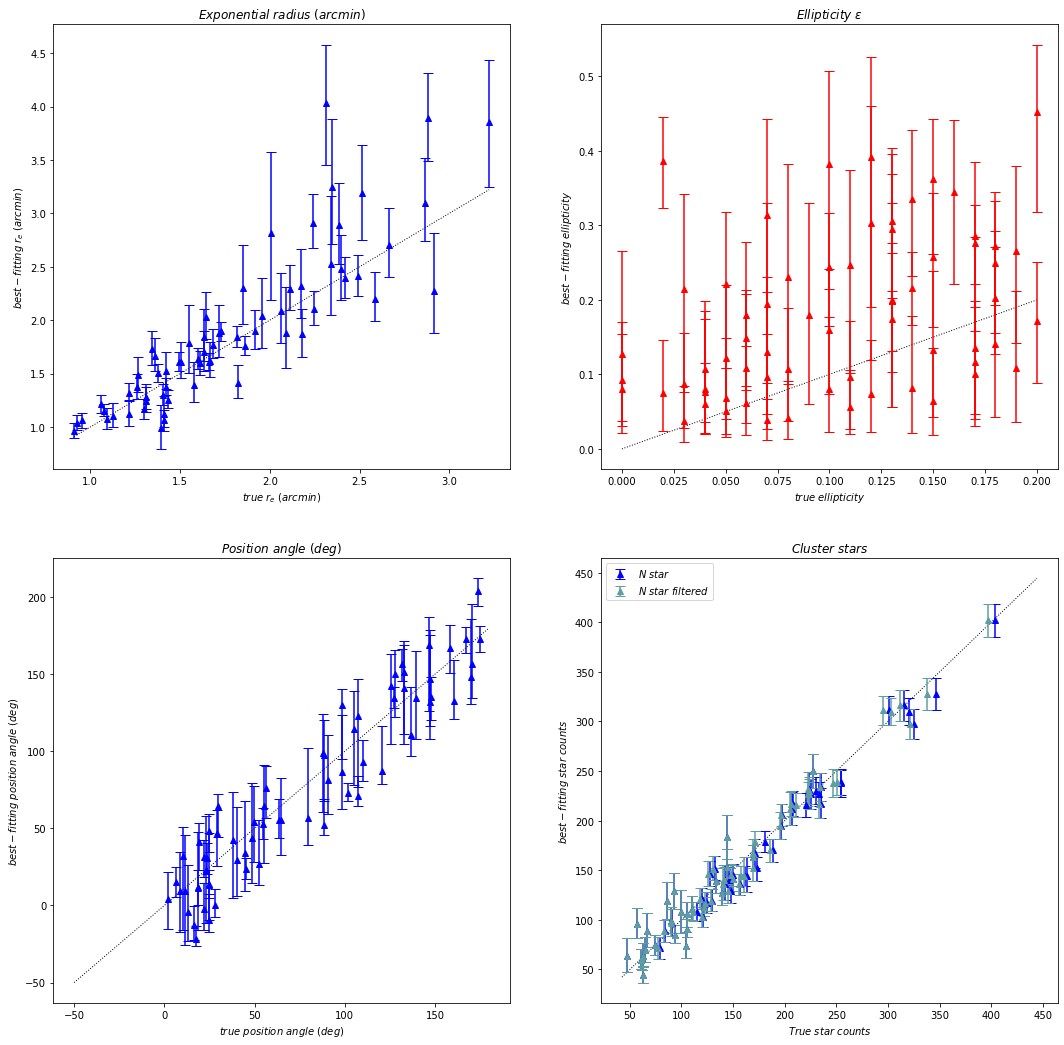

In [17]:
def identity(min_, max_):
    return np.linspace(min_, max_, 10)

fig, ax = plt.subplots(2, 2, figsize=(18, 18))

ax[0,0].plot(identity(np.min(re0_arcmin), np.max(re0_arcmin)), identity(np.min(re0_arcmin), np.max(re0_arcmin)), lw=1., color='k', ls=':')
ax[0,1].plot(identity(np.min(ell0), np.max(ell0)), identity(np.min(ell0), np.max(ell0)), lw=1., color='k', ls=':')
ax[1,0].plot(identity(-50., 180.), identity(-50., 180.), lw=1., color='k', ls=':')
ax[1,1].plot(identity(0.9*np.min(nstar0), 1.1*np.max(nstar0)), identity(0.9*np.min(nstar0), 1.1*np.max(nstar0)), lw=1., color='k', ls=':')

ax[0,0].errorbar(re0_arcmin, re_bf, np.array([re_bf_m, re_bf_p]), color='b', fmt='^', label=r'$r_e$', capsize=5)
ax[0,1].errorbar(ell0, ell_bf, np.array([ell_bf_m, ell_bf_p]), color='r', fmt='^', label=r'$ell$', capsize=5)
ax[1,0].errorbar(th0, th_bf, np.array([th_bf_m, th_bf_p]), color='b', fmt='^', label=r'$\theta$', capsize=5)
ax[1,1].errorbar(nstar0, nstar_bf, np.array([nstar_bf_m, nstar_bf_p]), color='b', fmt='^', label=r'$N\ star$', capsize=5)
ax[1,1].errorbar(nstar1, nstar_bf, np.array([nstar_bf_m, nstar_bf_p]), color='cadetblue', fmt='^', label=r'$N\ star\ filtered$', capsize=5)

ax[0,0].set_xlabel(r'$true\ r_e\ (arcmin)$')
ax[0,1].set_xlabel(r'$true\ ellipticity$')
ax[1,0].set_xlabel(r'$true\ position\ angle\ (deg)$')
ax[1,1].set_xlabel(r'$True\ star\ counts$')

ax[0,0].set_ylabel(r'$best-fitting\ r_e\ (arcmin)$')
ax[0,1].set_ylabel(r'$best-fitting\ ellipticity$')
ax[1,0].set_ylabel(r'$best-fitting\ position\ angle\ (deg)$')
ax[1,1].set_ylabel(r'$best-fitting\ star\ counts$')

ax[0,0].set_title(r'$Exponential\ radius\ (arcmin)$')
ax[0,1].set_title(r'$Ellipticity\ \epsilon$')
ax[1,0].set_title(r'$Position\ angle\ (deg)$')
ax[1,1].set_title(r'$Cluster\ stars$')

plt.legend()
plt.show()

/tmp/ipykernel_35014/1819512954.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b^" (-> color='b'). The keyword argument will take precedence.
  ax.errorbar(xc_bf, yc_bf, xerr=np.array([xc_bf_m, xc_bf_p]), yerr=np.array([yc_bf_m, yc_bf_p]), color='b', lw=1, fmt='b^', capsize=20)


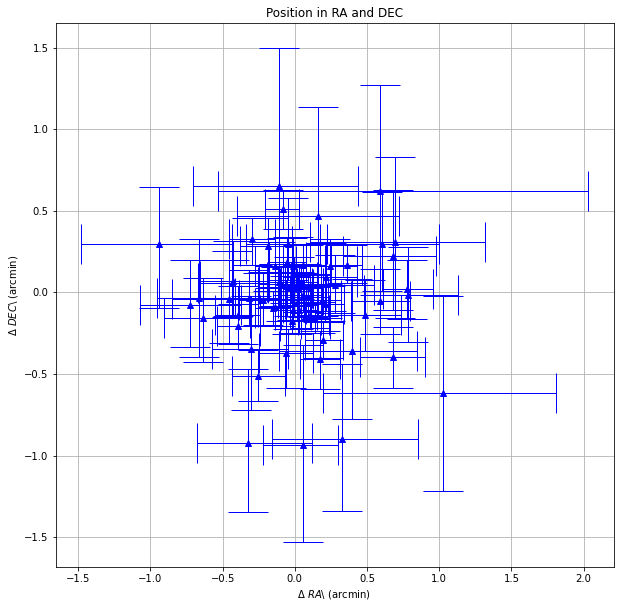

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.grid()
ax.errorbar(xc_bf, yc_bf, xerr=np.array([xc_bf_m, xc_bf_p]), yerr=np.array([yc_bf_m, yc_bf_p]), color='b', lw=1, fmt='b^', capsize=20)
ax.set_title('Position in RA and DEC')
ax.set_xlabel(r'$\Delta\ RA$\ (arcmin) ')
ax.set_ylabel(r'$\Delta\ DEC$\ (arcmin) ')
plt.show()

Plotting each fit trying to see a bias between exponential radius and ellipticity/positional angle.